<a href="https://colab.research.google.com/github/parasgodhani01/EmotionDetection_VGG16_RESNET50/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset - kaggle directory
Kaggle - https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 85% 51.0M/60.3M [00:00<00:00, 150MB/s] 
100% 60.3M/60.3M [00:00<00:00, 127MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

## Installing Packges

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

<ipython-input-4-ed049fea2f20>:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [30]:
from tensorflow import keras
from keras import layers,models, regularizers, optimizers
from keras.applications import VGG16,ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard , CSVLogger
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation,GlobalAveragePooling2D,Rescaling
from keras.models import Sequential,Model
from keras.optimizers import Adam,Adamax
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array

## Setting directory to save model

In [7]:
os.makedirs('test_dir',exist_ok=True)

In [8]:
project_name = "Emotion_Detection"

model_names = [
    'CNN_Scratch',
    'CNN_Augmentation',
    'VGG16',
    'ResNet50V2'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

for each_model in model_names:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)

print(f"Project Directory Structure Created at :{project_dir}")

Project Directory Structure Created at :/content/Emotion_Detection


## Data Cleaning

In [9]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

## Data Analysis

In [11]:
# this function is to count the total images for train and test for each class
def count_files_in_subdirs(directory,set_name):
  counts ={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)
    if os.path.isdir(item_path):
      counts[item]= len(os.listdir(item_path))
  df = pd.DataFrame(counts,index=[set_name])
  return df

train_df = '/content/train'
test_df = '/content/test'

train_count = count_files_in_subdirs(train_df,'train')
test_count = count_files_in_subdirs(test_df,'test')

print(train_count)
print(test_count)

       disgust  happy  fear  neutral   sad  surprise  angry
train      436   7215  4097     4965  4830      3171   3995
      disgust  happy  fear  neutral   sad  surprise  angry
test      111   1774  1024     1233  1247       831    958


<Axes: >

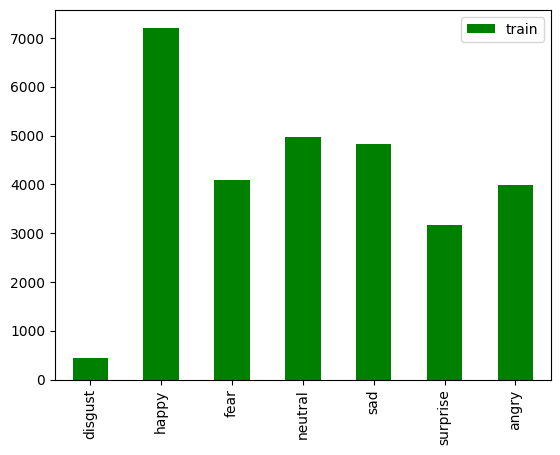

In [12]:
train_count.transpose().plot(kind='bar', color='green')

<Axes: >

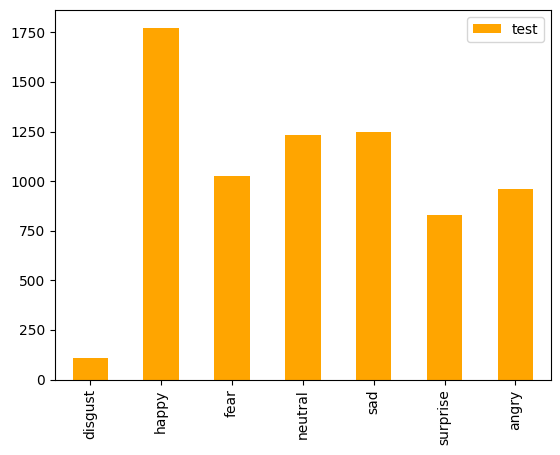

In [13]:
test_count.transpose().plot(kind='bar', color='orange')

## Plotting one image for each emotion

In [15]:
emotions = os.listdir(train_df)
print(emotions)

['disgust', 'happy', 'fear', 'neutral', 'sad', 'surprise', 'angry']


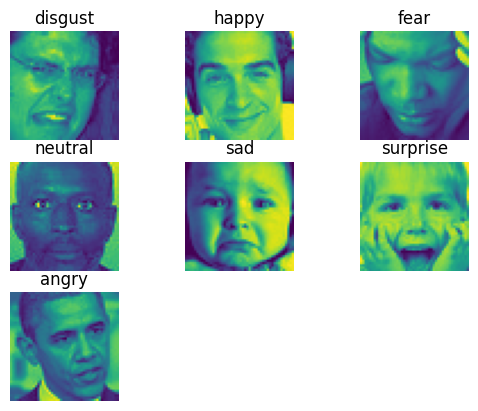

In [16]:
for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_df, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[5])
    img = plt.imread(img_path)
    plt.subplot(3,3, i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')

## Plotting random images from given directory

In [17]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3,3, figsize=(5, 5))
    axes = axes.ravel()   #2D t0 1D

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

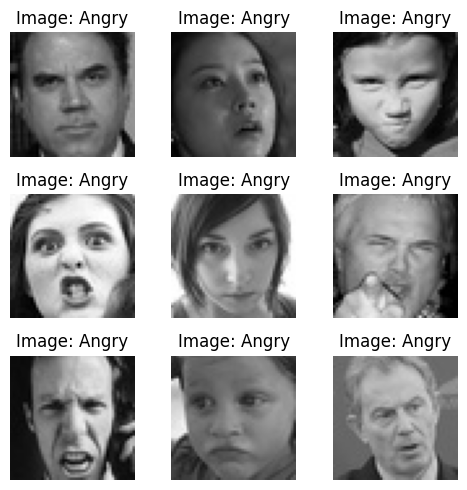

In [18]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

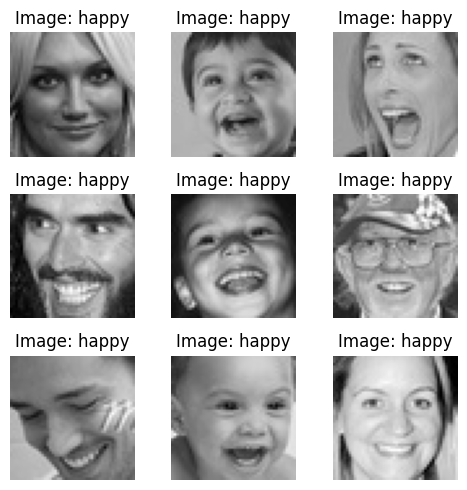

In [19]:
angry_directory_path = '/content/train/happy'
plot_images_from_directory(angry_directory_path, class_name = 'happy')

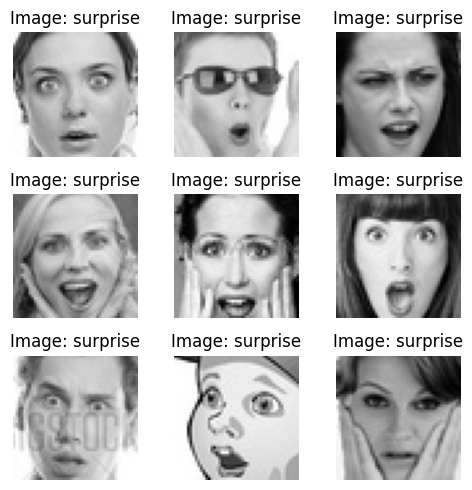

In [20]:
angry_directory_path = '/content/train/surprise'
plot_images_from_directory(angry_directory_path, class_name = 'surprise')

## Checking shape and channels.

In [21]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2
img = cv2.imread(image)
if img is not None:
    print("Shape:", img.shape)
else:
  print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


## Model 1 : Custom CNN from scratch

### Initializing the ImageGenerators

In [22]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [23]:
img_width ,img_height = 48,48
batch_size = 64
epochs = 10
num_classes =7

In [25]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

In [26]:
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    # subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
train_class_label = train_generator.class_indices
print(train_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [28]:
test_class_label = test_generator.class_indices
print(test_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [29]:
validation_class_label = validation_generator.class_indices
print(validation_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


### Initialising the CNN

In [34]:
inputs =keras.Input(shape=(img_width, img_height, 1))

x = Rescaling(1./255)(inputs)

x = Conv2D(32,kernel_size=(3,3),kernel_initializer="glorot_uniform", padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=(3,3), padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(128,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(256,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │              

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [38]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

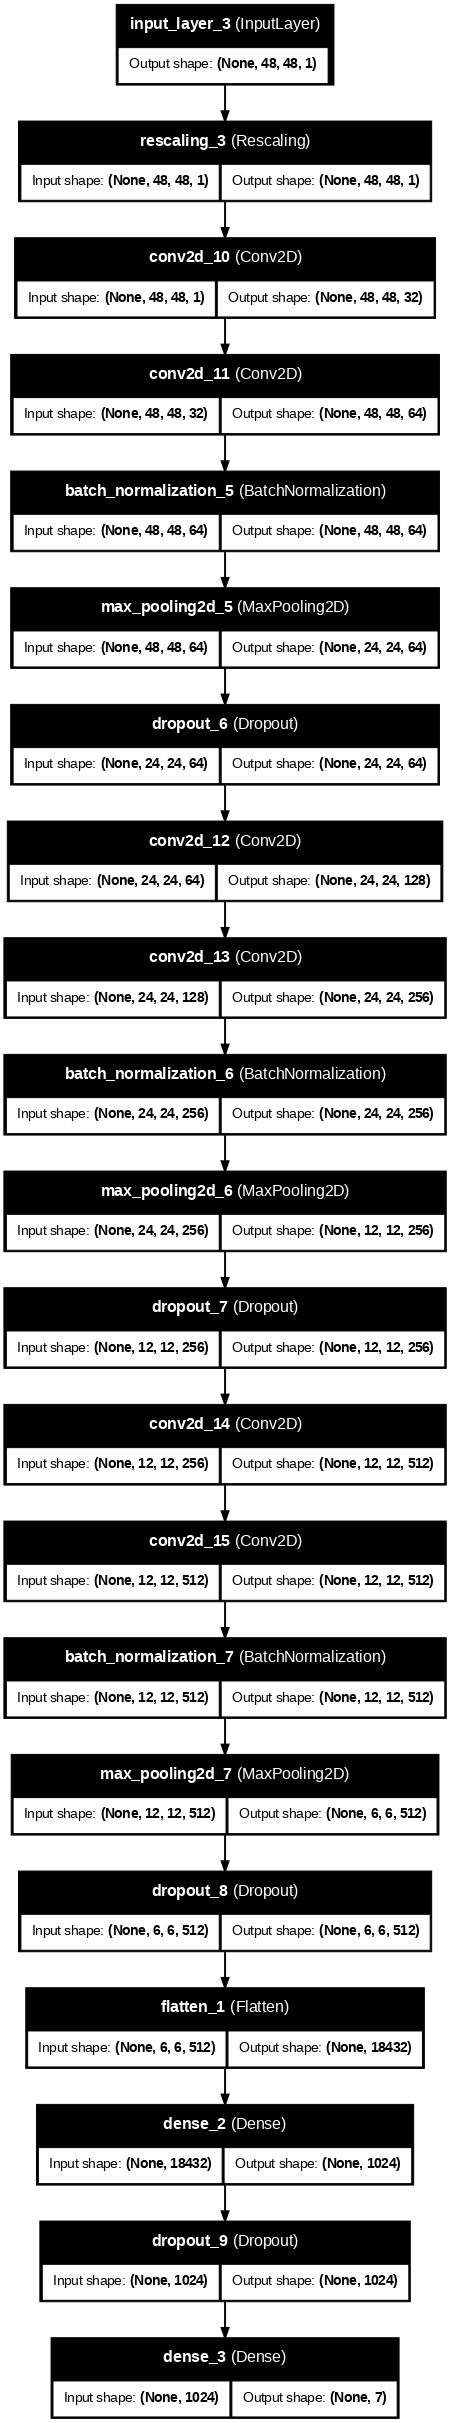

In [44]:
import pydot
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

## Callbacks

In [45]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [46]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [47]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [48]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [56]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr]  # Adjusted as per your use-case

## Steps for epoch

In [51]:
train_generator.samples

22968

In [52]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [53]:
print(train_steps_per_epoch)
print(validation_steps_epoch)
print(test_steps_epoch)

359
90
113


## Model Training

In [57]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks
)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2404 - loss: 7.0077

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.97195, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 80s 166ms/step - accuracy: 0.2405 - loss: 6.9991 - val_accuracy: 0.1683 - val_loss: 1.9720 - learning_rate: 0.0010
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3723 - loss: 1.6654
Epoch 2: val_loss did not improve from 1.97195
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 97ms/step - accuracy: 0.3724 - loss: 1.6653 - val_accuracy: 0.1423 - val_loss: 2.1441 - learning_rate: 0.0010
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4217 - loss: 1.5461
Epoch 3: val_loss improved from 1.97195 to 1.96227, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.4217 - loss: 1.5461 - val_accuracy: 0.3217 - val_loss: 1.9623 - learning_rate: 0.0010
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/s

##Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step


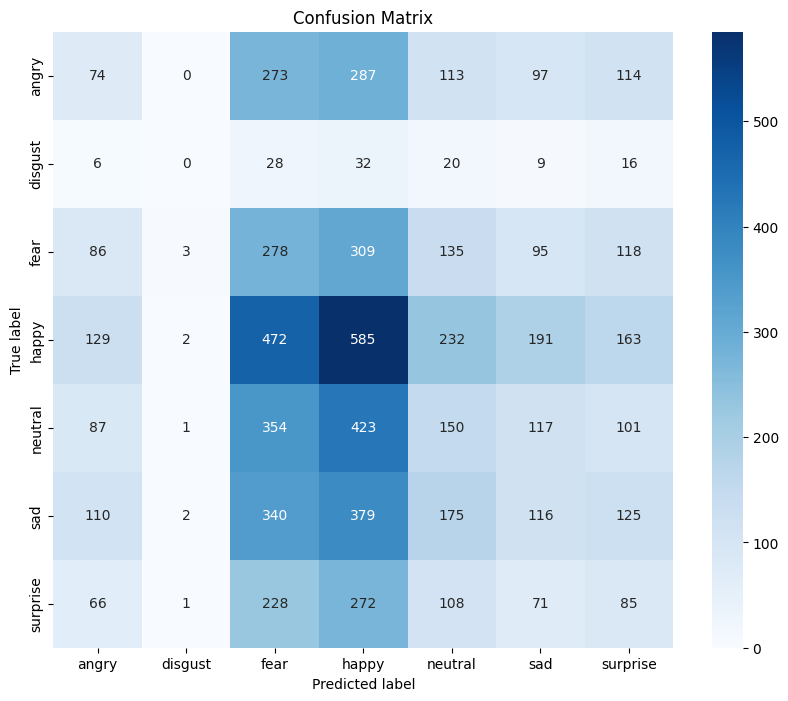

In [58]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1) # Convert steps to an integer
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

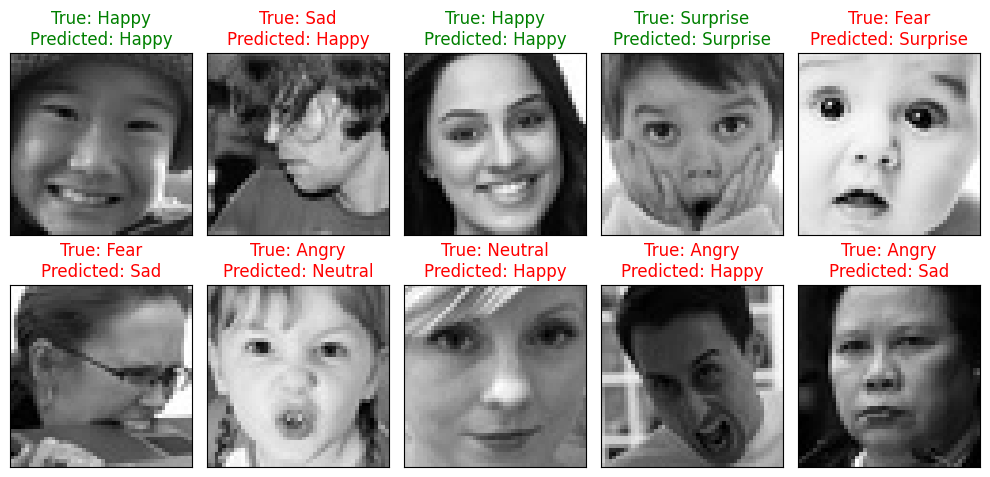

In [59]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()